In [1]:
#import needed libraries、
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from autoencoder_pipeline import train_autoencoder
from VAE_pipeline import train_vae
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import lightgbm as lgb
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier


# 选择设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 数据准备

In [2]:
df_application_record = pd.read_csv("application_record.csv")
df_credit_record = pd.read_csv("credit_record.csv")

print(df_application_record.info())
print(df_application_record.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [3]:
#For each set of duplicate ID's drop both of them
df_application_record = df_application_record.drop_duplicates(subset = 'ID', keep = False)
df_application_record.info()

<class 'pandas.core.frame.DataFrame'>
Index: 438463 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438463 non-null  int64  
 1   CODE_GENDER          438463 non-null  object 
 2   FLAG_OWN_CAR         438463 non-null  object 
 3   FLAG_OWN_REALTY      438463 non-null  object 
 4   CNT_CHILDREN         438463 non-null  int64  
 5   AMT_INCOME_TOTAL     438463 non-null  float64
 6   NAME_INCOME_TYPE     438463 non-null  object 
 7   NAME_EDUCATION_TYPE  438463 non-null  object 
 8   NAME_FAMILY_STATUS   438463 non-null  object 
 9   NAME_HOUSING_TYPE    438463 non-null  object 
 10  DAYS_BIRTH           438463 non-null  int64  
 11  DAYS_EMPLOYED        438463 non-null  int64  
 12  FLAG_MOBIL           438463 non-null  int64  
 13  FLAG_WORK_PHONE      438463 non-null  int64  
 14  FLAG_PHONE           438463 non-null  int64  
 15  FLAG_EMAIL           4

In [4]:
#show how many unique IDs we will be able to work with in the dataframes
print("# of unique IDs that are consistent between both datasets", df_application_record[df_application_record['ID'].isin(df_credit_record['ID'])]['ID'].nunique())

#adjust the dataframes so that we only work with the consistent IDs
df_application_record = df_application_record[df_application_record['ID'].isin(df_credit_record['ID'])]
df_credit_record = df_credit_record[df_credit_record['ID'].isin(df_application_record['ID'])]
print("New # of IDs in application_record", df_application_record['ID'].nunique())
print("New # of IDs in credit_record", df_credit_record['ID'].nunique())

# of unique IDs that are consistent between both datasets 36457
New # of IDs in application_record 36457
New # of IDs in credit_record 36457


# 数据清洗

In [5]:
df_credit_record['APPROVED'] = df_credit_record['STATUS'].map({'1':0,'2':0,'3':0,'4':0,'5':0,'X':-1,'C':1,'0':1})
df_credit_record = df_credit_record[df_credit_record['APPROVED']!=-1]
df_credit_record['STATUS'].value_counts()

STATUS
C    329536
0    290654
1      8747
5      1527
2       801
3       286
4       214
Name: count, dtype: int64

In [6]:
df_application_record = df_application_record.merge(df_credit_record, on='ID')
df_application_record.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,APPROVED
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,0,C,1
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-1,C,1
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-2,C,1
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-3,C,1
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-4,C,1
5,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-5,C,1
6,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-6,C,1
7,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-7,C,1
8,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-8,C,1
9,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,-9,C,1


In [7]:
df_application_record = df_application_record[df_application_record['MONTHS_BALANCE']==-4]
df_application_record.loc[df_application_record["NAME_INCOME_TYPE"]=="Pensioner","OCCUPATION_TYPE"] = "Pension"
df_application_record.loc[df_application_record["NAME_INCOME_TYPE"]=="Commercial associate","OCCUPATION_TYPE"] = "Commercial associate"
df_application_record.loc[df_application_record["NAME_INCOME_TYPE"]=="State servant","OCCUPATION_TYPE"] = "State servant"
df_application_record.loc[df_application_record["NAME_INCOME_TYPE"]=="Student","OCCUPATION_TYPE"] = "Student"
df_application_record = df_application_record.dropna()
df_application_record.isna().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
MONTHS_BALANCE         0
STATUS                 0
APPROVED               0
dtype: int64

Work_Time
 3       1384
 8        887
-1001    3313
 2       1393
 4       1422
 5       1030
 12       375
 19       131
 14       330
 6       1084
 17       122
 29        45
 7        821
 1       1607
 15       276
 11       362
 10       515
 23        89
 24        50
 13       238
 0       1195
 20       153
 9        656
 26        36
 18       150
 21        78
 22        99
 16       133
 28        23
 27        54
 38         5
 32        27
 31        27
 36         5
 37         1
 30         9
 34        11
 25        88
 33        21
 39        10
 41        13
 40         8
 35        27
 43         1
 42         2
Name: count, dtype: int64


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,APPROVED,Work_Time
33,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,1,0,0,0,Security staff,2.0,-4,1,3
49,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,1,0,1,1,Commercial associate,1.0,-4,1,8
70,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,1,0,1,1,Commercial associate,1.0,-4,1,8
145,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,1,1,1,1,Accountants,2.0,-4,1,2
148,5112956,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,1,1,1,1,Accountants,2.0,-4,1,2


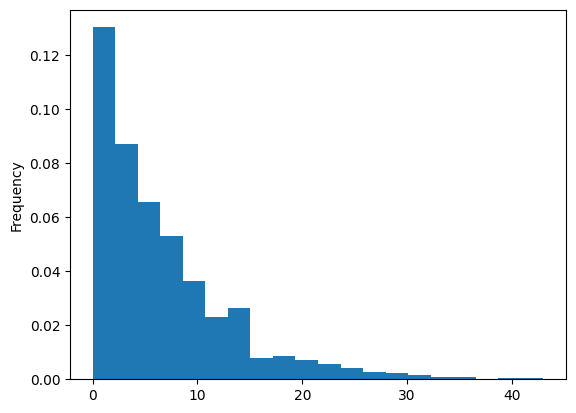

In [8]:
df_application_record['Work_Time'] = -(df_application_record['DAYS_EMPLOYED'])//365
print(df_application_record['Work_Time'].value_counts(sort=False))

df_application_record = df_application_record.drop(df_application_record[df_application_record['Work_Time']>50].index)
df_application_record = df_application_record.drop(df_application_record[df_application_record['Work_Time']<0].index)
df_application_record['Work_Time'].plot(kind='hist',bins=20,density=True)
df_application_record = df_application_record.drop(columns=['STATUS'])
df_application_record.drop(['DAYS_EMPLOYED'],axis=1,inplace=True)
df_application_record.head()


In [9]:
baseline_date = pd.to_datetime('2023-01-01')
df_application_record['BIRTH_DATE'] = baseline_date + pd.to_timedelta(df_application_record['DAYS_BIRTH'], unit='D')
df_application_record['AGE'] = (baseline_date - df_application_record['BIRTH_DATE']).dt.days // 365
df_application_record = df_application_record.drop(columns=['DAYS_BIRTH','BIRTH_DATE'])
df_application_record.isna().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
MONTHS_BALANCE         0
APPROVED               0
Work_Time              0
AGE                    0
dtype: int64

In [10]:
categorical_columns = ['CODE_GENDER', 'NAME_FAMILY_STATUS', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
dummy_columns = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
categorical_df = df_application_record[categorical_columns]
categorical_df = categorical_df.apply(lambda x: pd.factorize(x)[0])
categorical_df = pd.DataFrame(categorical_df)
df_application_record[categorical_columns] = categorical_df
df_application_record = pd.get_dummies(df_application_record, columns=dummy_columns)
print(df_application_record['APPROVED'].value_counts())
df_application_record.to_csv('dataset.csv', index=False)
print(df_application_record.columns)
df_application_record.head()


APPROVED
1    14693
0      300
Name: count, dtype: int64
Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_FAMILY_STATUS', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
       'MONTHS_BALANCE', 'APPROVED', 'Work_Time', 'AGE',
       'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree',
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_HOUSING_TYPE_Co-op apartment',
       'NAME_HOUSING_TYPE_House / apartment',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Office apartment',
       'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_Wi

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_FAMILY_STATUS,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,...,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Pension,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_State servant,OCCUPATION_TYPE_Student,OCCUPATION_TYPE_Waiters/barmen staff
33,5008806,0,0,0,0,112500.0,0,1,0,0,...,False,False,False,False,False,False,True,False,False,False
49,5008810,1,1,0,0,270000.0,1,1,0,1,...,False,False,False,False,False,False,False,False,False,False
70,5008811,1,1,0,0,270000.0,1,1,0,1,...,False,False,False,False,False,False,False,False,False,False
145,5008815,0,0,0,0,270000.0,0,1,1,1,...,False,False,False,False,False,False,False,False,False,False
148,5112956,0,0,0,0,270000.0,0,1,1,1,...,False,False,False,False,False,False,False,False,False,False


# 创建数据集

In [11]:
# scaler = MinMaxScaler()
# df_application_record['AMT_INCOME_TOTAL']=scaler.fit_transform(df_application_record['AMT_INCOME_TOTAL'].values.reshape(-1, 1))
# df_application_record['DAYS_EMPLOYED']=scaler.fit_transform(df_application_record['DAYS_EMPLOYED'].values.reshape(-1, 1))
# df_application_record['MONTHS_BALANCE']=scaler.fit_transform(df_application_record['MONTHS_BALANCE'].values.reshape(-1, 1))
# scaler = StandardScaler()
# df_application_record['CNT_FAM_MEMBERS']=scaler.fit_transform(df_application_record['CNT_FAM_MEMBERS'].values.reshape(-1, 1))
# df_application_record['AGE']=scaler.fit_transform(df_application_record['AGE'].values.reshape(-1, 1))

negative_data_orgin = df_application_record[df_application_record['APPROVED']==0]
negative_data = negative_data_orgin.drop(['APPROVED', 'ID','CODE_GENDER'], axis = 1)

print(df_application_record.columns)
X = df_application_record.drop(['APPROVED', 'ID','CODE_GENDER'], axis = 1) 
y = df_application_record['APPROVED']
X = np.array(X,dtype=float)
y = np.array(y, dtype=int)
print(X.shape)

print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y)

negative_data = np.array(negative_data,dtype=float)

# 创建 RandomUnderSampler 对象
undersampler = RandomUnderSampler(sampling_strategy='majority')

# 使用 RandomUnderSampler 来生成平衡的训练集
X_train_under_random, y_train_under_random = undersampler.fit_resample(X_train, y_train)

# 创建RandomOverSampler对象
oversampler = RandomOverSampler(sampling_strategy='minority')

# 使用RandomOverSampler来生成平衡的训练集
X_train_over_random, y_train_over_random = oversampler.fit_resample(X_train, y_train)

# 创建TomekLinks对象
undersampler = TomekLinks()

# 使用TomekLinks来生成平衡的训练集
X_train_under_tomelinks, y_train_under_tomelinks = undersampler.fit_resample(X_train, y_train)

# 创建SMOTE对象
smote = SMOTE(sampling_strategy='minority')

# 使用SMOTE来生成平衡的训练集
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_FAMILY_STATUS', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
       'MONTHS_BALANCE', 'APPROVED', 'Work_Time', 'AGE',
       'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree',
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_HOUSING_TYPE_Co-op apartment',
       'NAME_HOUSING_TYPE_House / apartment',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Office apartment',
       'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents',
       'OCCUPATION_TYPE_Accountants', 'OCCUP

In [12]:
data_list = [
            #  (X_train, y_train, "Original Data"),
             (X_train_over_random,y_train_over_random, "Over-sampled Data"),
             (X_train_under_random,y_train_under_random, "Under-sampled Data"),
            #  (X_train_under_tomelinks,y_train_under_tomelinks, "Tomelinks Data"),
             (X_train_smote,y_train_smote, "SMOTE Data")]


# 特征提取

In [13]:
model_list = []
for X_train_processed, _, method_name in data_list:
   print("Training for the method: " + method_name)
   # model = train_autoencoder(X_train=X_train_processed,X_test=X_test, progress=True,num_epoch=100).eval()
   model = train_vae(X_train=X_train_processed,X_test=X_test, progress=True,num_epoch=100).eval()
   model_list.append(model)


Training for the method: Over-sampled Data


Best epoch: 99
Training for the method: Under-sampled Data


Best epoch: 99
Training for the method: SMOTE Data


Best epoch: 99


In [14]:
total_list = [ t+ (data,)  for t, data in zip(data_list, model_list)]
# print(total_list)

In [15]:
# for X_train_processed, _, method_name, model in data_list:
#     model.eval()
#     with torch.no_grad():
#         encoded_data = model.encoder(torch.Tensor(X_train_processed).to(device))
#         encoded_data = encoded_data.cpu().numpy()
#         tsne = TSNE(n_components=2)
#         reduced_data = tsne.fit_transform(encoded_data)

# plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
# plt.title("VAE Visualization")
# plt.show()

In [16]:
index = 0
train_features = []
test_features = []
negative_data_list = []
neagtive_label_list = np.zeros(len(negative_data))
for X_train_processed, _, method_name, __ in total_list:
    print(len(X_train_processed),len(_))
    train_features.append(model_list[index].encoder(torch.Tensor(X_train_processed).to(device)).cpu().detach().numpy())
    test_features.append(model_list[index].encoder(torch.Tensor(X_test).to(device)).detach().cpu().numpy())
    negative_data_list.append(model_list[index].encoder(torch.Tensor(negative_data).to(device)).detach().cpu().numpy())
    index+=1

22062 22062
426 426
22062 22062


# 分类

## LightGBM

In [ ]:
params = {
    'objective': 'rmse', 
    'learning_rate': 0.05,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 100, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62,
    'force_col_wise':True,
}

In [ ]:
index = 0

performance_data = []
data_df = pd.DataFrame(columns=['Method', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Negative Accuracy'])

for X_train_processed, y_train_processed, method_name, _ in total_list:
   print(train_features[index].shape)
   lgb_model = lgb.LGBMClassifier(**params)


   lgb_model.fit(train_features[index], y_train_processed)
   y_pred = lgb_model.predict(test_features[index])
   
   conf_matrix = confusion_matrix(y_test, y_pred)
   accuracy = accuracy_score(y_test, y_pred)
   precision = precision_score(y_test, y_pred)
   recall = recall_score(y_test, y_pred)
   f1 = f1_score(y_test, y_pred)
#    print(f'Method: {method_name}')
#    print(f'Accuracy: {accuracy:.2f}')
#    print(f'Precision: {precision:.2f}')
#    print(f'Recall: {recall:.2f}')
#    print(f'F1 Score: {f1:.2f}')
   print(classification_report(y_test,y_pred))
   negative_data_pred = lgb_model.predict(negative_data_list[index])
   negative_accuracy = accuracy_score(neagtive_label_list, negative_data_pred)

#    print(f'Negative Accuracy: {negative_accuracy:.2f}')
   print(classification_report(neagtive_label_list,negative_data_pred))

#    print(negative_data_pred)
   performance_data.append({
        'Method': method_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Negative Accuracy': negative_accuracy,
    })
   index +=1

data_df = pd.DataFrame(performance_data)
print(data_df)


In [ ]:
# 找到最佳性能数据的行
best_accuracy_row = data_df[data_df['Accuracy'] == data_df['Accuracy'].max()]
best_precision_row = data_df[data_df['Precision'] == data_df['Precision'].max()]
best_recall_row = data_df[data_df['Recall'] == data_df['Recall'].max()]
best_f1_score_row = data_df[data_df['F1 Score'] == data_df['F1 Score'].max()]
best_negative_accuracy_row = data_df[data_df['Negative Accuracy'] == data_df['Negative Accuracy'].max()]

# 输出最佳性能数据
print("Best Accuracy Method:", best_accuracy_row['Method'].values[0])
print("Best Accuracy Value:", best_accuracy_row['Accuracy'].values[0])

print("Best Precision Method:", best_precision_row['Method'].values[0])
print("Best Precision Value:", best_precision_row['Precision'].values[0])

print("Best Recall Method:", best_recall_row['Method'].values[0])
print("Best Recall Value:", best_recall_row['Recall'].values[0])

print("Best F1 Score Method:", best_f1_score_row['Method'].values[0])
print("Best F1 Score Value:", best_f1_score_row['F1 Score'].values[0])

print("Best Negative Accuracy Method:", best_negative_accuracy_row['Method'].values[0])
print("Best Negative Accuracy Value:", best_negative_accuracy_row['Negative Accuracy'].values[0])
data_df.to_csv('performance_data.csv', index=False)


## RandomForest

In [ ]:
for X_train_processed, y_train_processed, method_name in data_list:
    rfc = RandomForestClassifier(n_estimators = 1000, max_features = 12)
    rfc.fit(X_train_processed, y_train_processed)
    predictions = rfc.predict(X_test)
    print(classification_report(y_test,predictions))
    predictions = rfc.predict(negative_data)
    print(classification_report(neagtive_label_list, predictions))

In [ ]:
index = 0
for X_train_processed, y_train_processed, method_name in data_list:
    train_feature = train_features[index]
    test_feature = test_features[index]
    rfc = RandomForestClassifier(n_estimators = 1000, max_features = 12)
    rfc.fit(train_feature, y_train_processed)
    predictions = rfc.predict(test_feature)
    print(classification_report(y_test,predictions))
    predictions = rfc.predict(negative_data[index])
    print(classification_report(neagtive_label_list, predictions))
    index = index + 1